## CS 372

### Assignment 2 - Decision Trees

- Grace Biggs

- Brandon L'Abbe

- Lane Thompson

- Zhiyi Zhan

### Exploratory Data Analysis (Grace Biggs)

We begin this Decision Tree assignment by parsing the provided XLSX file into a Pandas dataframe for future modification. Our target feature is the binary Personal Loan field, denoting whether a customer accepted a personal loan offer during the bank's last campaign. Besides that, our other features are:

- Binary: Personal Loan, Securities Account, CD Account, Online, Credit Card
- Continuous: Age, Experience, Income, CCAvg, Mortgage
- Ordinal: Family
- Categorical: Education
- Other: ZIP Code

We drop the ID column per the assignment instructions as it contains no useful information. Similar to the ID, the ZIP Code feature is also of dubious use in constructing a Decision Tree - while it may encode some useful information regarding a customer's geoeconomic status, we would need to treat it as a broad categorical feature with dozens if not hundreds of sparsely-populated categories that may not generalize well. As we'll see later, there is also an extremely high correlation between the Age and Experience features, and we could theoretically drop one or the other from our dataframe safely, but will leave them in for the sake of posterity. 

There are no duplicates in the dataframe, and just 6 missing values. Because only 6 rows out of 5000 (0.12%) are missing data, we can safely drop the rows with missing values.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_excel('Personal Loan Data_DT.xlsx', sheet_name='Data')
df = df.drop(columns=['ID']) # Drop ID column - provides no useful info.
# df = df.drop(columns=['Age']) # Extremely high correlation between Age and Experience. Drop Age?

print("First 10 rows in Dataframe: ")
print(df.head(10))
print("Number of Duplicates: ")
print(df.duplicated().sum()) # 0 duplicates.
print("Number of missing values: ")
print(df.isnull().sum()) # 2 missing experience, 4 missing education
# We're making a Decision Tree from this dataset of 5000 rows. Because only 6 rows (0.12%) are missing data, we can safely drop them.
df = df.dropna()

First 10 rows in Dataframe: 
   Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   47        23.0     148     94551       2    7.5  Undergrad         0   
1   48        24.0      71     93117       2    1.7  Undergrad       145   
2   62        37.0      58     91320       4    1.7  Undergrad         0   
3   57        32.0      28     95831       3    0.2  Undergrad         0   
4   51        26.0      70     90089       1    1.2  Undergrad       169   
5   41        17.0      78     94025       4    0.8  Undergrad        78   
6   55        29.0      99     92121       2    1.4  Undergrad       264   
7   65        40.0      53     91711       3    2.2  Undergrad         0   
8   47        21.0     138     94583       1    0.0  Undergrad         0   
9   66        41.0      18     92691       3    0.5  Undergrad         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   0           1       1       

Next up, we check for outliers by creating boxplots of the continuous variables in the dataframe. Age and Experience do not contain outliers, while Income, CCAvg, and Mortgage predictably contain wealthy/indebted outliers as their values grow further from 0. Because we split the decision tree based on purity and not the distance between feature values, we don't need to do anything special as far as preprocessing for outliers goes. What we *do* need to be conscious of later is overfitting and pruning, but for now that's not an issue, and so we'll leave the outliers alone.

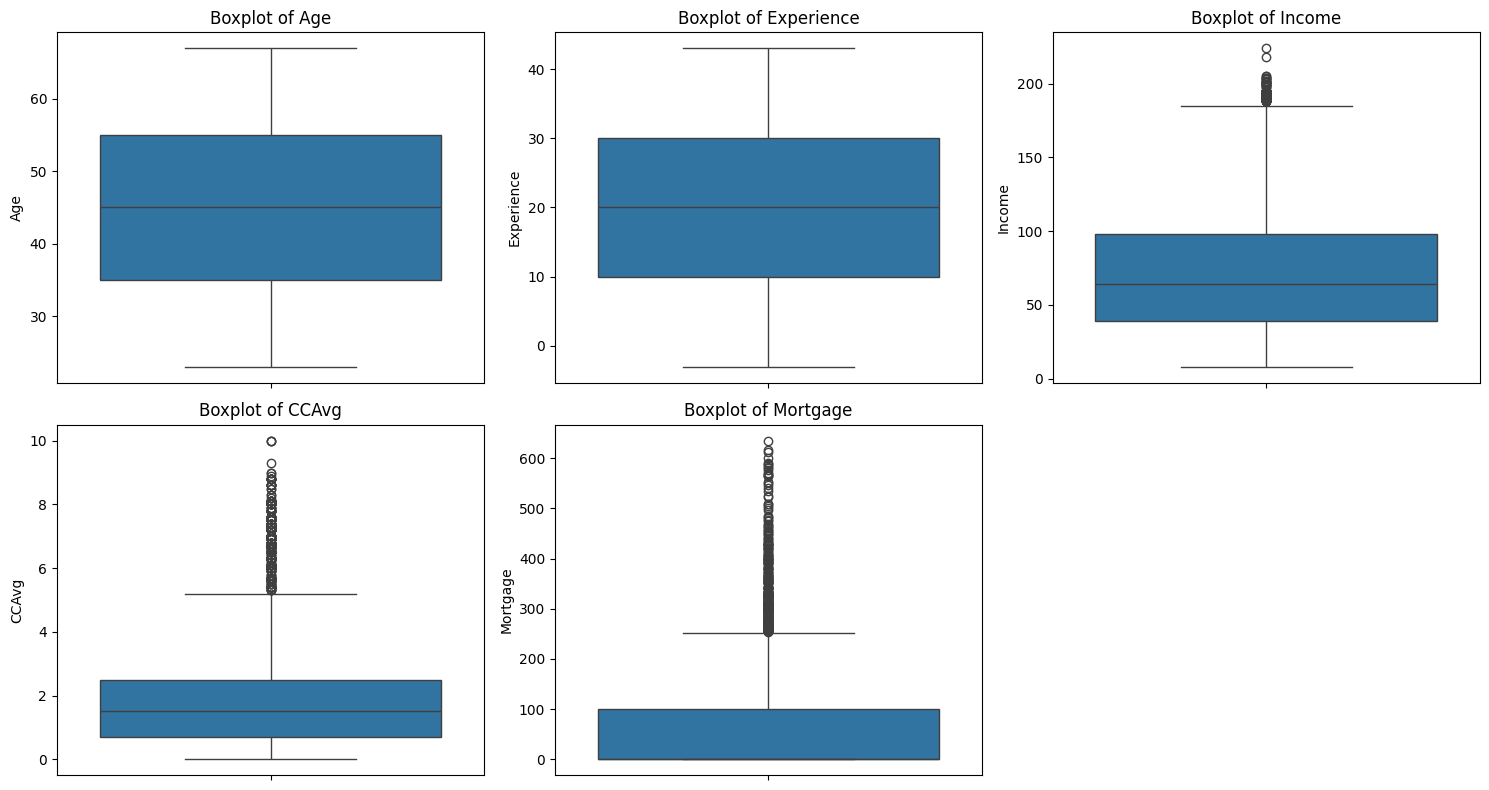

In [2]:
# Check for outliers with Boxplots. 
continuous_vars = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
plt.figure(figsize=(15,8))
for i, col in enumerate(continuous_vars, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

Next, a scatter plot matrix of the continuous variables. As mentioned earlier, Age and Experience are *very* linearly correlated and we could probably drop one or the other from the dataframe without issue, but won't for posterity. Income seems moderately correlated to CCAvg and Mortgage. Everything else looks too noisy to draw strong conclusions about.

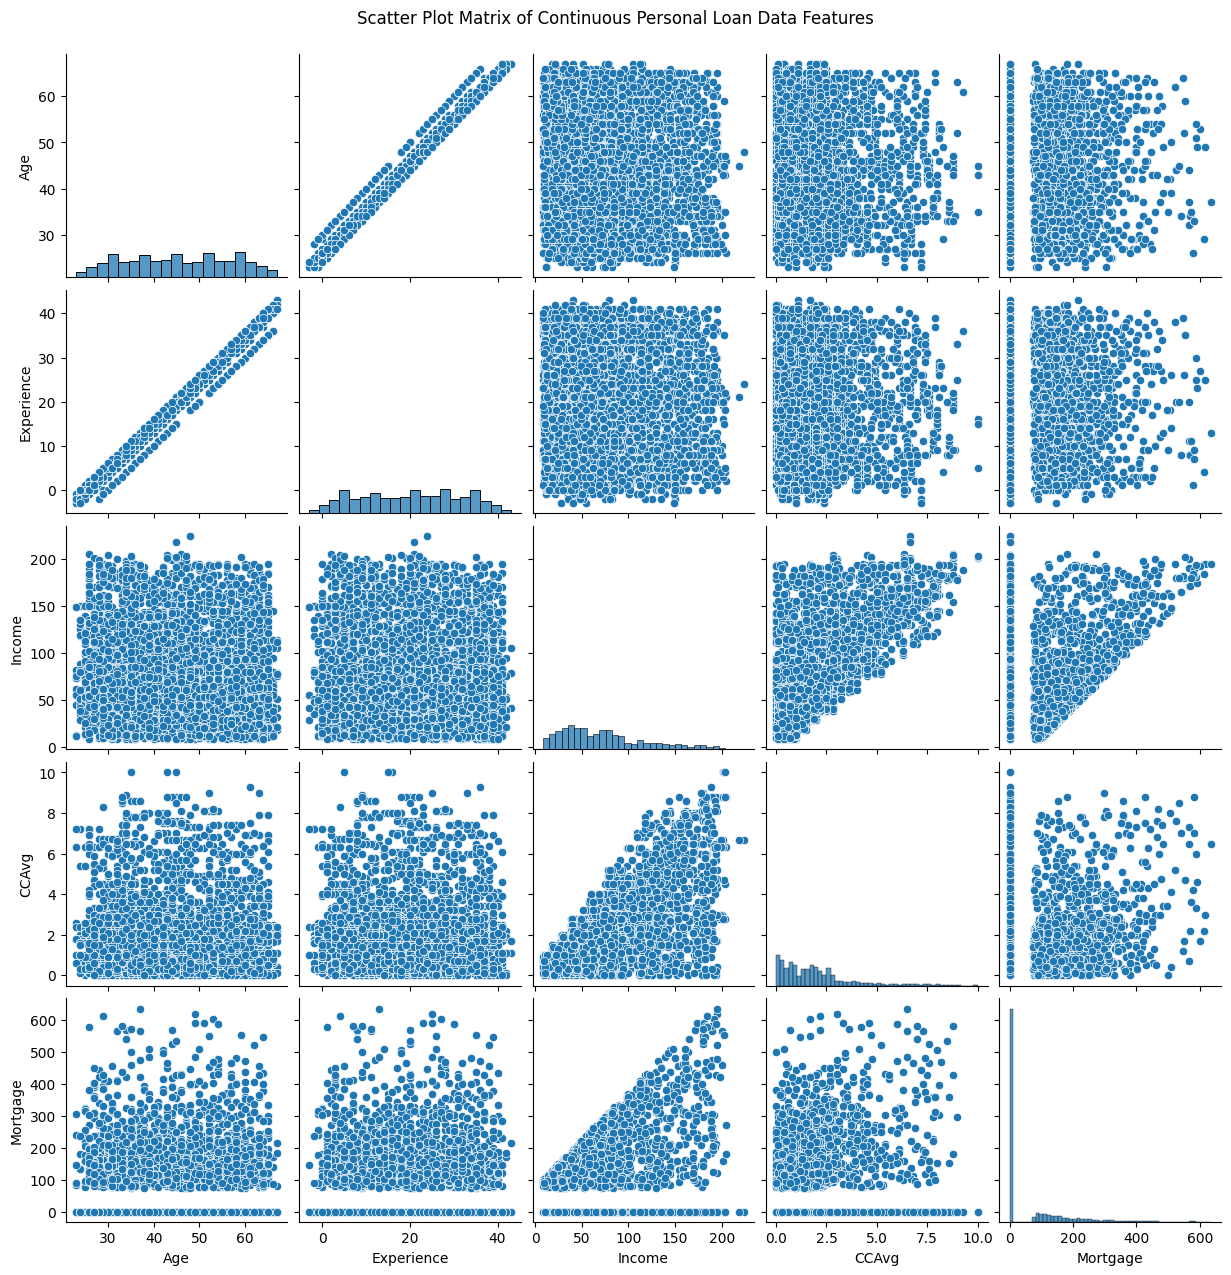

In [3]:
# Draw scatter plot matrix for all features. Comment.
sns.pairplot(df[continuous_vars])
plt.suptitle('Scatter Plot Matrix of Continuous Personal Loan Data Features', y=1.02)
plt.show()

Finally, a heatmap plot between all of our continuous, binary, and ordinal features. Besides the obvious correlation between Age and Experience, the next-hottest correlation is between Income and CCAvg. Looking at the Personal Loan correlations, we can see that the most important features influencing whether a customer accepts a loan are their Income, CCAvg, CD Account, and Mortgage. CD Account in particular is in turn positively correlated with other features like Securities Account, Online, and CreditCard. On the flip side, Family has the chilliest relationship with other features out of any of them, with the most notable negative correlation being between Family and Income. 

By this heatmap, we should expect our Decision Tree to look at the Income, CCAvg, Mortgage, and CD Account features when predicting if a customer will accept a Personal Loan, and by extension, it may also look closely at features associated with CD Accounts as well.

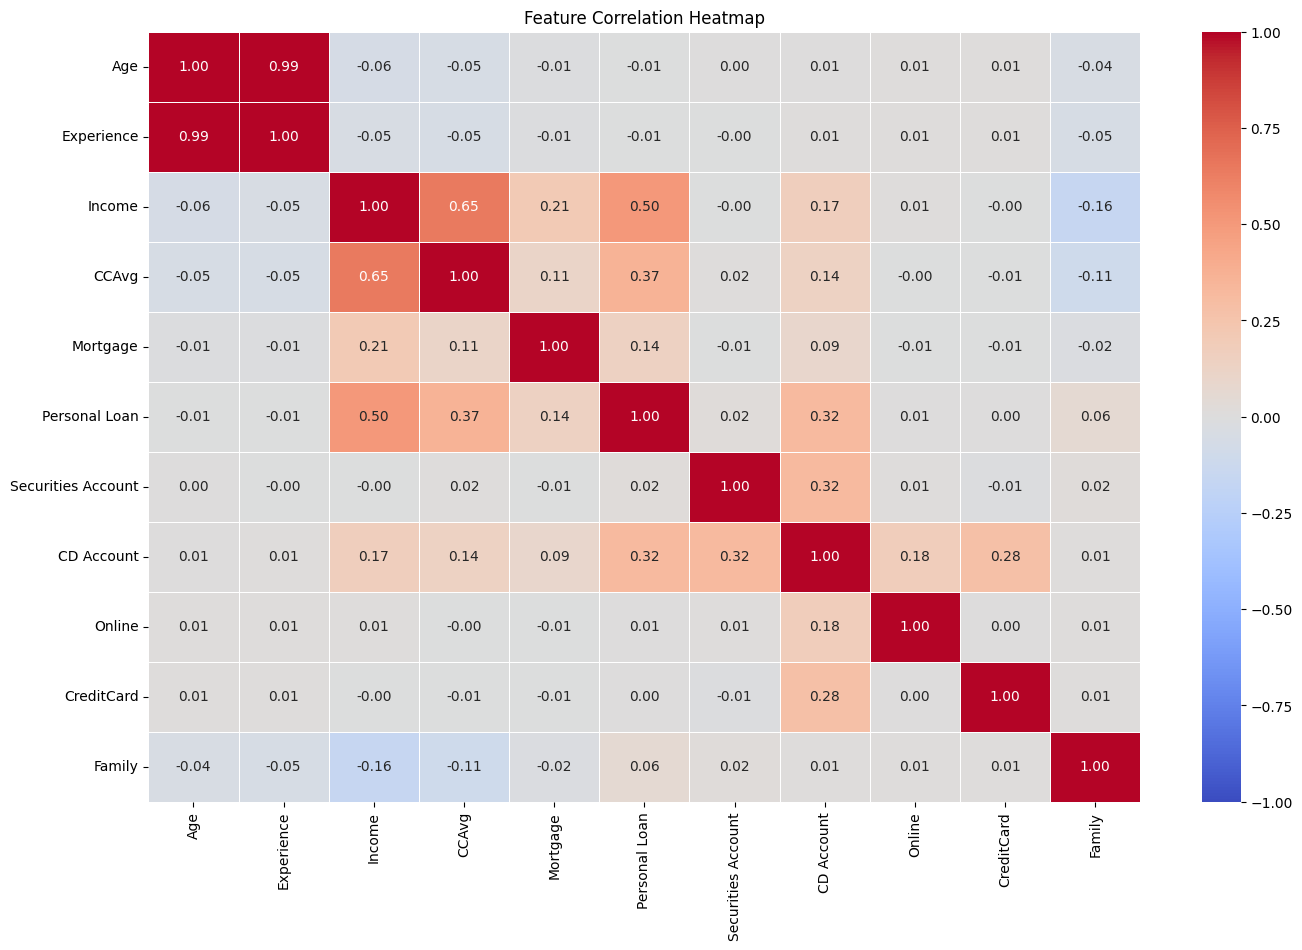

In [4]:
# Draw a heatmap plot between features. Comment.
binary_vars = ['Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']
ordinal_vars = ['Family']
numeric_vars = continuous_vars + binary_vars + ordinal_vars

plt.figure(figsize=(16,10))
sns.heatmap(df[numeric_vars].corr(), annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

## Decision Trees
#### Grace Biggs, Brandon L'Abbe, Lane Thompson

Time taken to train Gini Tree:  0.006129264831542969
Gini Tree Score:  0.974974974974975
Time taken to train Entropy Tree:  0.005070924758911133
Entropy Tree Score:  0.972972972972973


[Text(0.4887640449438202, 0.9615384615384616, 'Family <= 98.5\nentropy = 0.456\nsamples = 3995\nvalue = [3612, 383]\nclass = Decline'),
 Text(0.23595505617977527, 0.8846153846153846, 'Mortgage <= 2.95\n0.07\n2995\n[2970, 25]\nDecline'),
 Text(0.21348314606741572, 0.8076923076923077, '0.0\n2831\n[2831, 0]\nDecline'),
 Text(0.25842696629213485, 0.8076923076923077, 'CD Account <= 0.5\n0.616\n164\n[139, 25]\nDecline'),
 Text(0.21348314606741572, 0.7307692307692307, 'Mortgage <= 3.95\n0.516\n156\n[138, 18]\nDecline'),
 Text(0.19101123595505617, 0.6538461538461539, 'Family <= 81.5\n0.639\n111\n[93, 18]\nDecline'),
 Text(0.11235955056179775, 0.5769230769230769, 'Income <= 36.5\n0.33\n66\n[62, 4]\nDecline'),
 Text(0.06741573033707865, 0.5, 'Education <= 3.5\n0.918\n9\n[6, 3]\nDecline'),
 Text(0.0449438202247191, 0.4230769230769231, 'Mortgage <= 3.5\n0.811\n4\n[1, 3]\nAccept'),
 Text(0.02247191011235955, 0.34615384615384615, '0.0\n3\n[0, 3]\nAccept'),
 Text(0.06741573033707865, 0.34615384615384

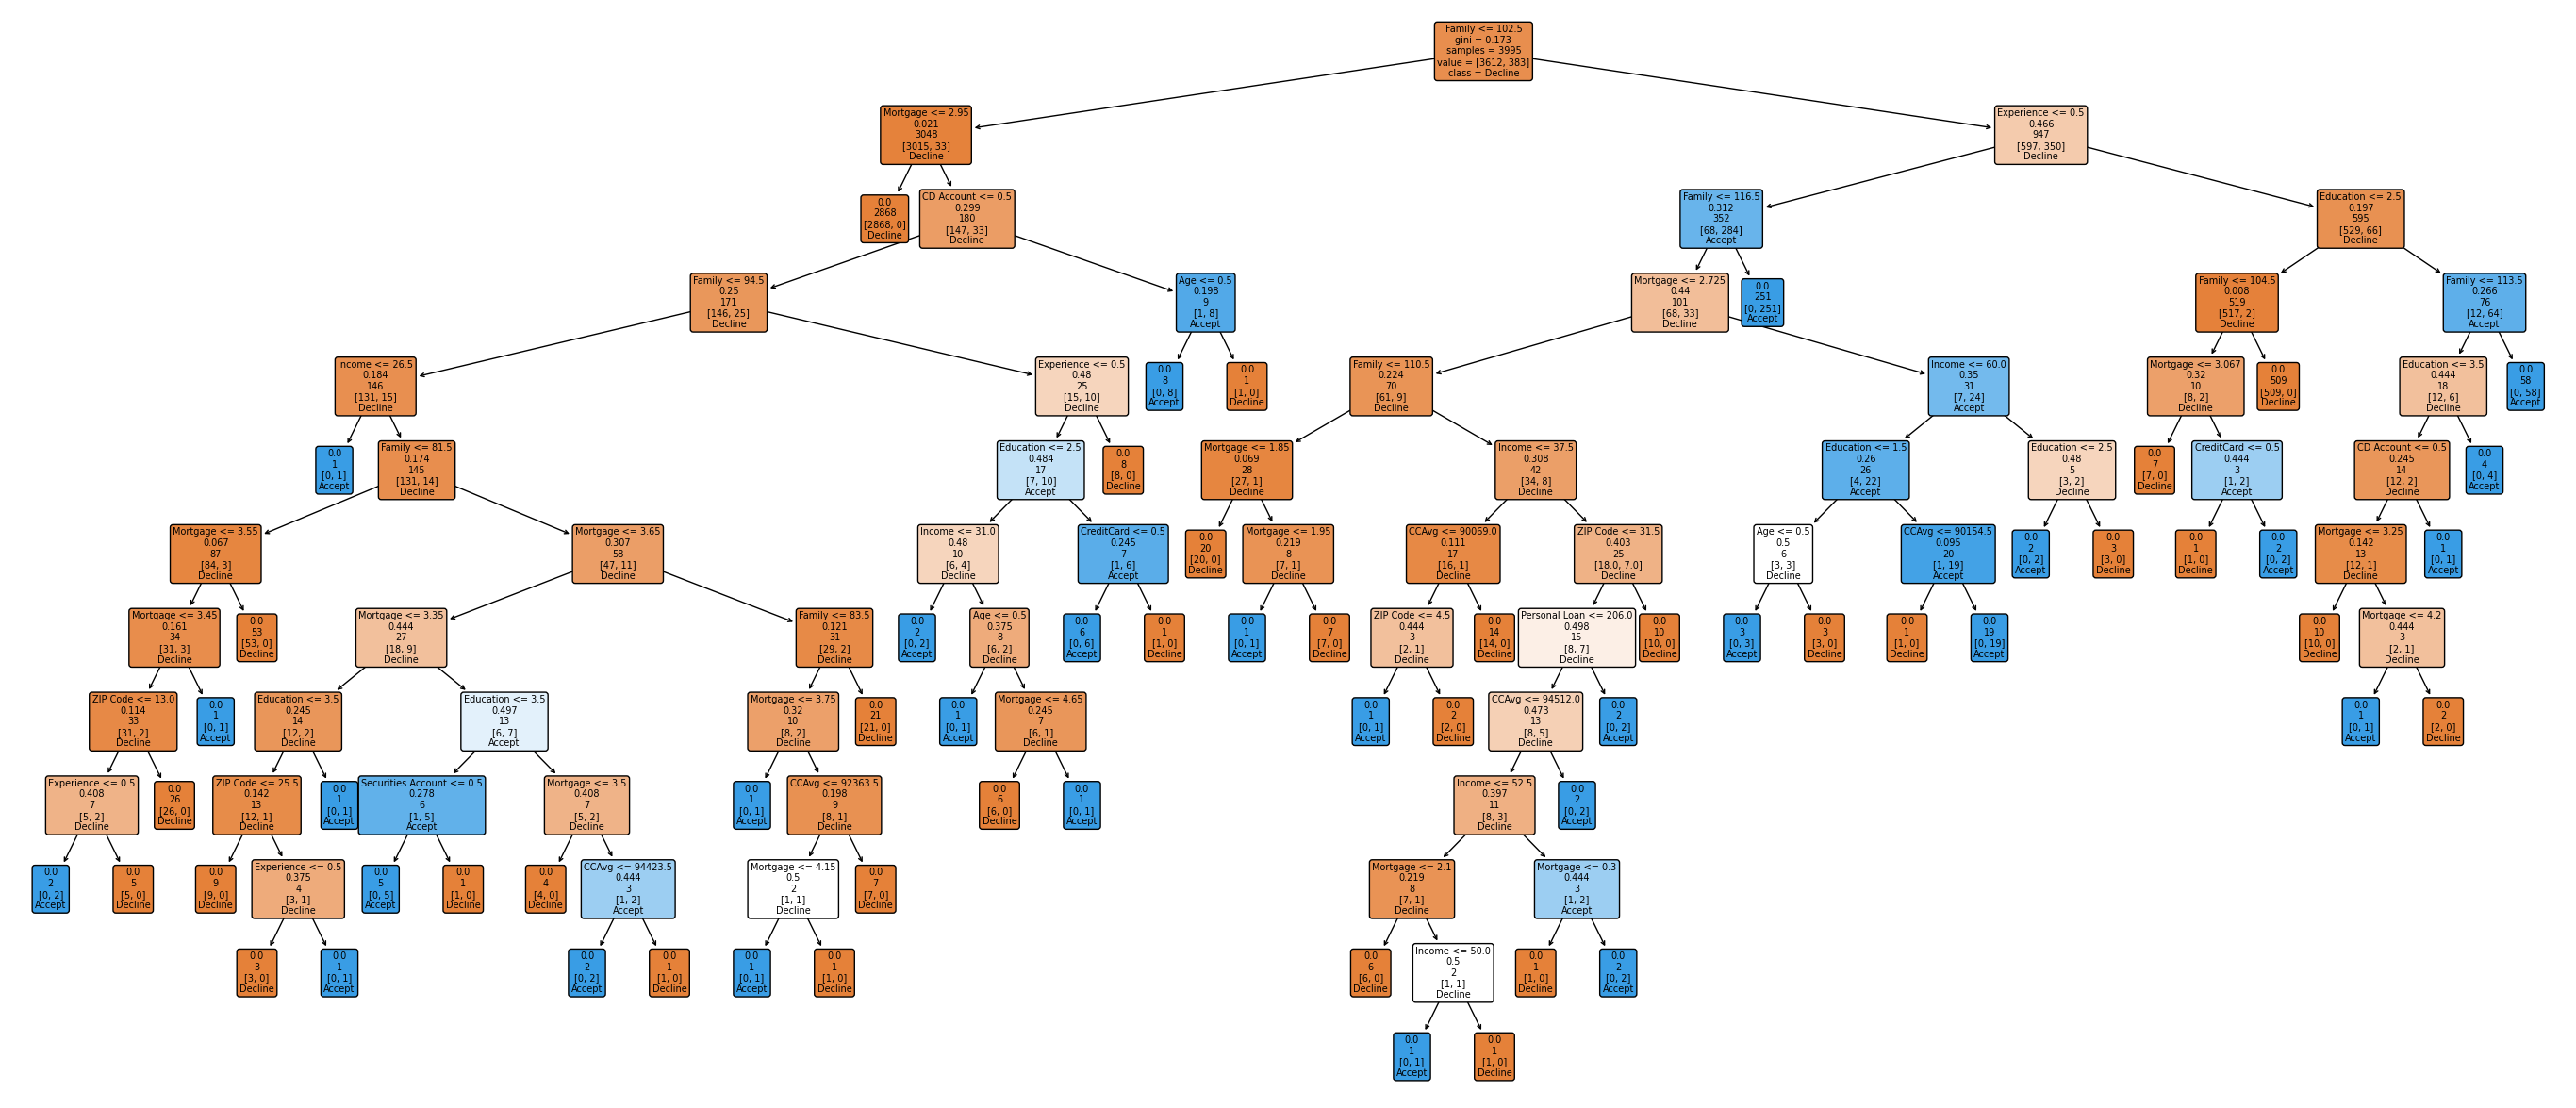

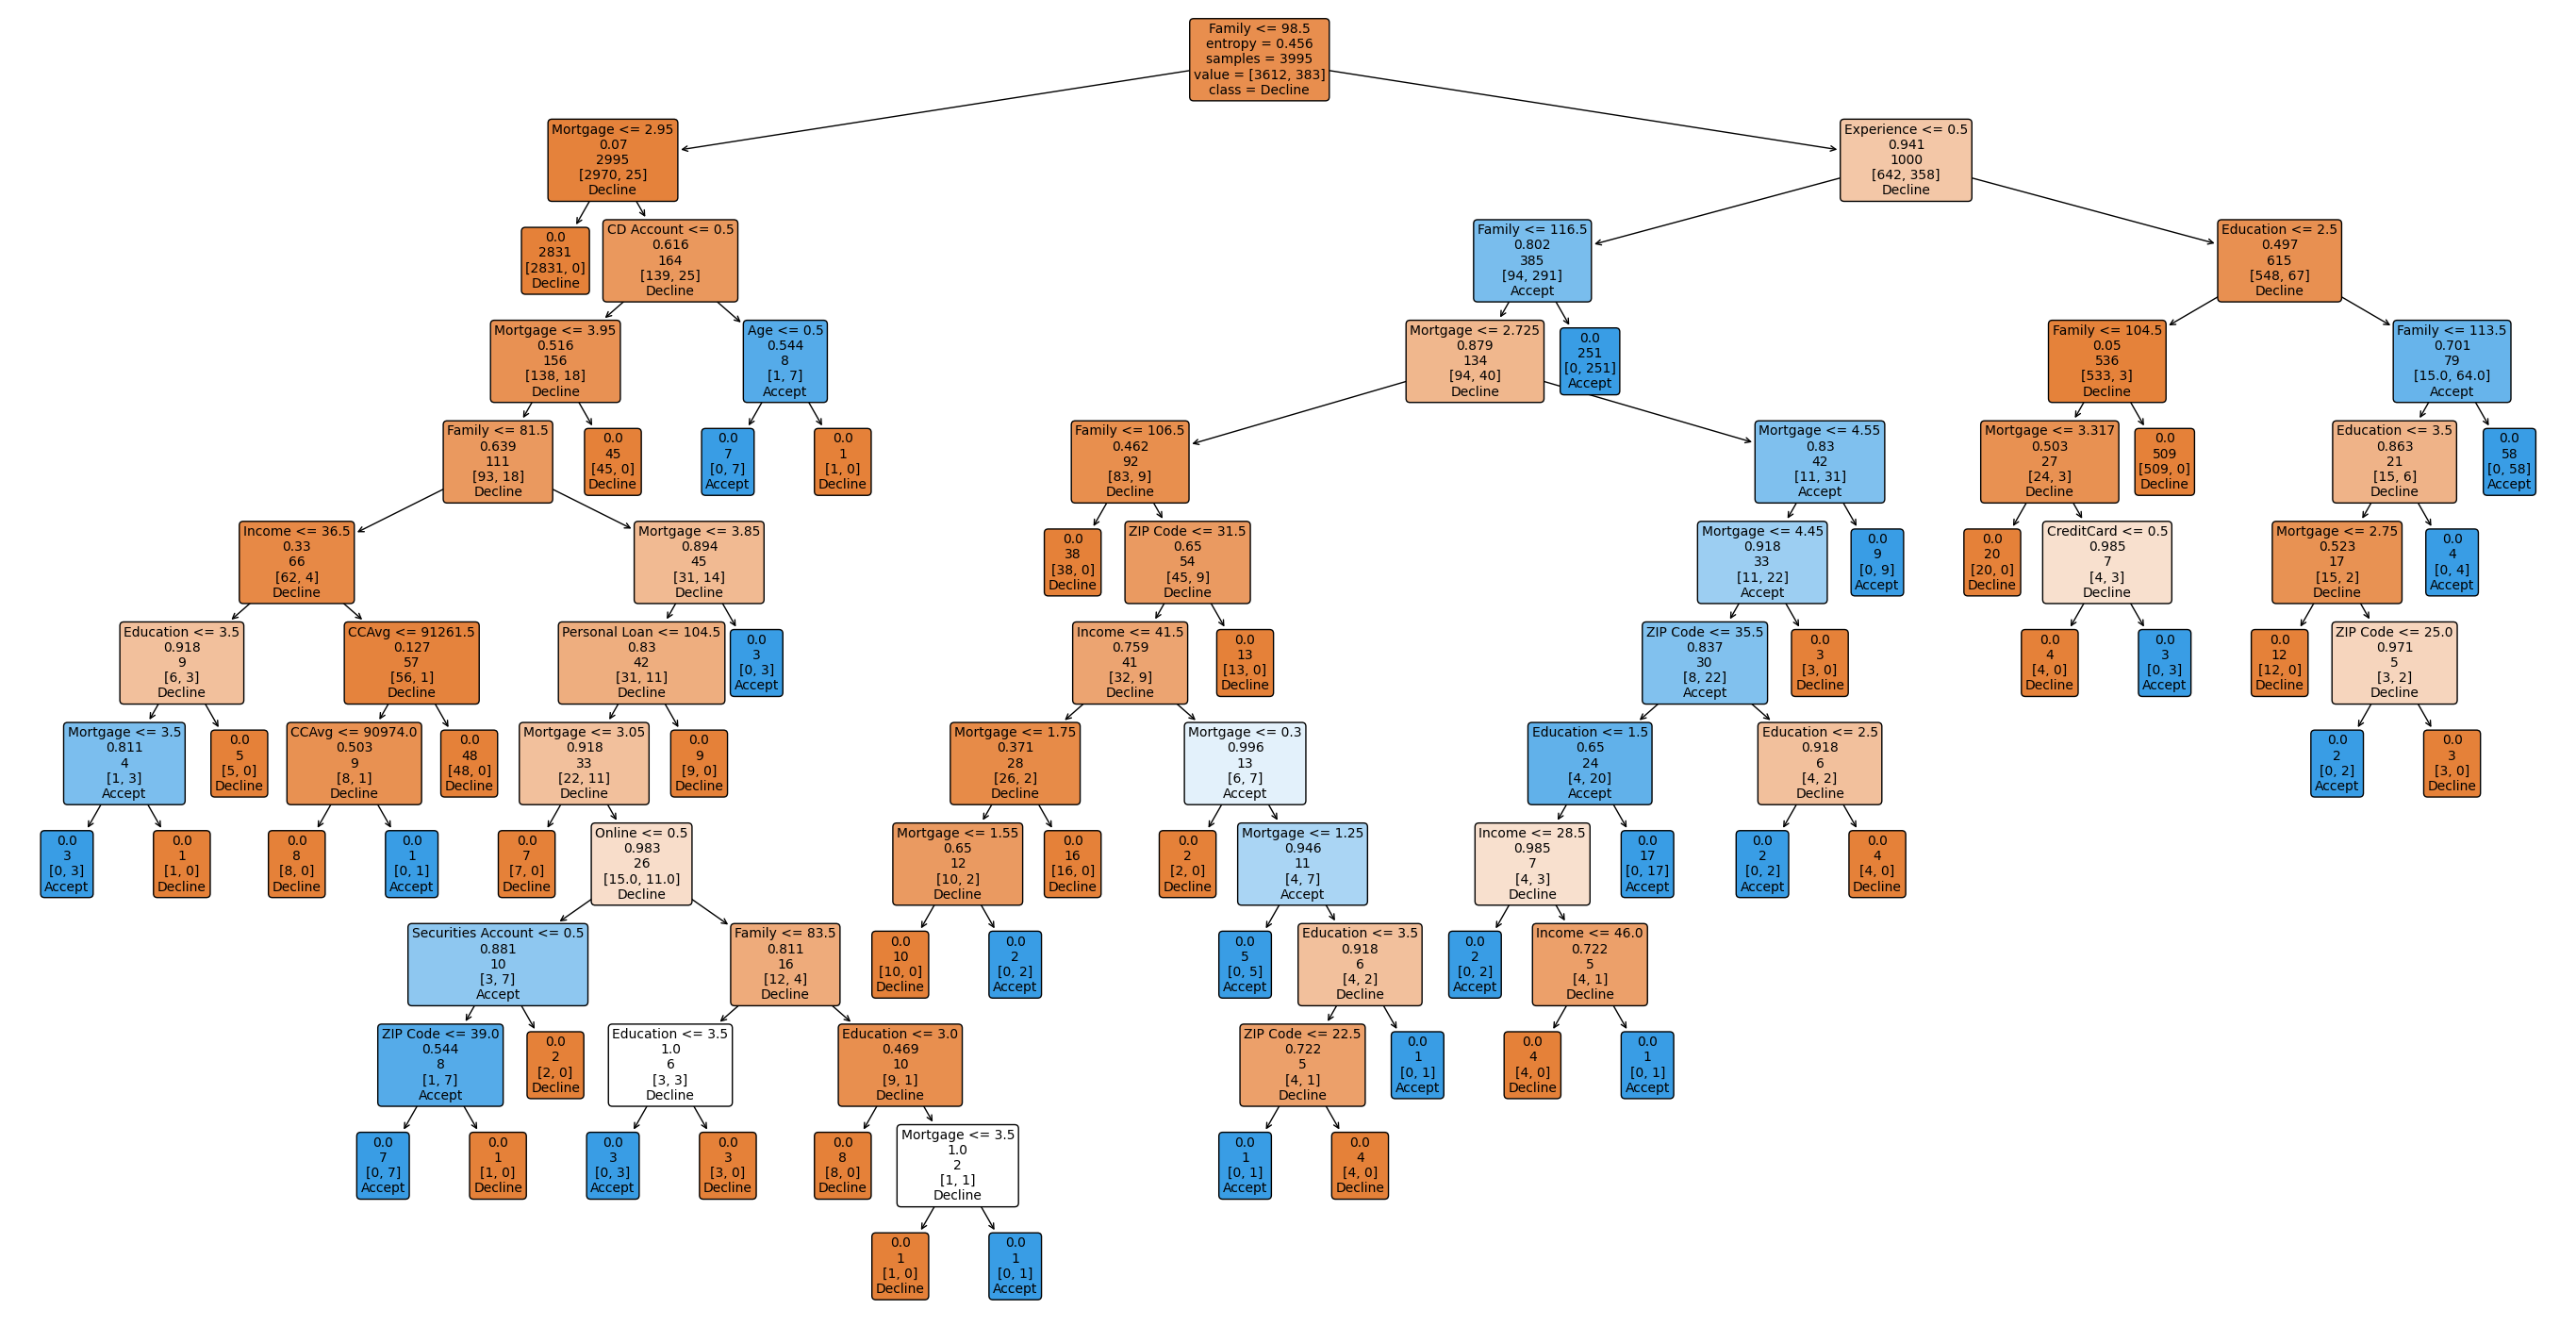

In [5]:
import sklearn.compose
import sklearn.model_selection
import sklearn.tree

import time

X = df.drop(columns=['Personal Loan'])
y = df['Personal Loan']
# Convert categorical columns into one-hots with ColumnTransformer()
ct = sklearn.compose.ColumnTransformer(
    transformers=[('cat', sklearn.preprocessing.OneHotEncoder(drop='first'), ['Education'])],
    remainder='passthrough'
)
state_value = 42
# Apply the transformation to the features
X_processed = ct.fit_transform(X)
# split the data into training and validation sets
data_train, data_test, label_train, label_test = sklearn.model_selection.train_test_split(X_processed, y, test_size=0.2, random_state=state_value, stratify=y)

# Build and compare two Decision Trees, based on Gini Impurity and Entropy.
start = time.time()
gini_tree = sklearn.tree.DecisionTreeClassifier(criterion='gini',random_state=state_value)
gini_tree.fit(data_train, label_train)
end = time.time()
gini_train_time = end - start
print("Time taken to train Gini Tree: ", gini_train_time)
print("Gini Tree Score: ", gini_tree.score(data_test, label_test))
start = time.time()
entropy_tree = sklearn.tree.DecisionTreeClassifier(criterion='entropy',random_state=state_value)
entropy_tree.fit(data_train, label_train)
end = time.time()
entropy_train_time = end - start
print("Time taken to train Entropy Tree: ", entropy_train_time)
print("Entropy Tree Score: ", entropy_tree.score(data_test, label_test))


# Visualize the fully-grown Decision Trees you built with a tree graph. 
# Include the feature name in the visualization of the trees, not the index of the feature.
plt.figure(figsize=(35,15))
sklearn.tree.plot_tree(gini_tree, fontsize=7, feature_names=df.columns, class_names=["Decline", "Accept"], label='root', filled=True, rounded=True) # TODO: Does this feature names list include the target feature? (Personal Loan?) Also, are these class names in the right order?

plt.figure(figsize=(35,18))
sklearn.tree.plot_tree(entropy_tree, fontsize=10, feature_names=df.columns, class_names=["Decline", "Accept"], label='root', filled=True, rounded=True)

## Model Evaluation
#### Lane Thompson
- Evaluate the performance of your classifier using:
    - execution time
    - accuaracy
    - confusion matrix (comment on the results)
- Analyze, explain, and comment on the evaluation results
- How does the Number of training sample affect performance (accuracy, time, etc.)? Explain and draw graphs to support your claims.

#### Gini Impurity

Execution time: 0.0006 seconds
Accuracy: 0.9750
Confusion Matrix:


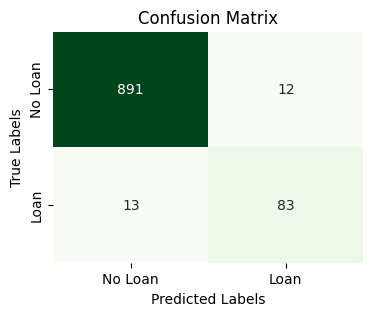

In [6]:
## Evaluate the performance of your classifier using:
# execution time
import time
import sklearn

start = time.time()
label_prediction = gini_tree.predict(data_test)
end = time.time()
gini_test_time = end - start
print(f"Execution time: {gini_test_time:.4f} seconds")
# accuracy
accuracy = sklearn.metrics.accuracy_score(label_test, label_prediction)
print(f"Accuracy: {accuracy:.4f}")
# confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(label_test, label_prediction)
print("Confusion Matrix:")
plt.figure(figsize=(4, 3))
sns.heatmap(sklearn.metrics.confusion_matrix(label_test, label_prediction),
            annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Loan', 'Loan'], yticklabels=['No Loan', 'Loan'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

#### Entropy

Execution time: 0.0010 seconds
Accuracy: 0.9730
Confusion Matrix:


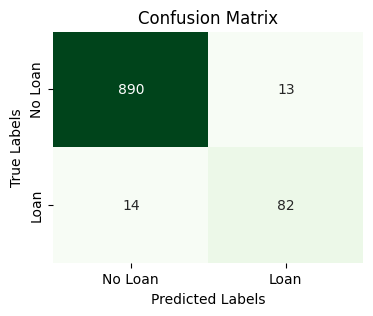

In [7]:
## Evaluate the performance of your classifier using:
# execution time
import time
import sklearn

start = time.time()
label_prediction = entropy_tree.predict(data_test)
end = time.time()
entropy_test_time = end - start
print(f"Execution time: {entropy_test_time:.4f} seconds")
# accuracy
accuracy = sklearn.metrics.accuracy_score(label_test, label_prediction)
print(f"Accuracy: {accuracy:.4f}")
# confusion matrix
confusion_matrix = sklearn.metrics.confusion_matrix(label_test, label_prediction)
print("Confusion Matrix:")
plt.figure(figsize=(4, 3))
sns.heatmap(sklearn.metrics.confusion_matrix(label_test, label_prediction),
            annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['No Loan', 'Loan'], yticklabels=['No Loan', 'Loan'])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

def split_and_test(X, y, test_size=0.5, random_state=None, tree_type='gini'):
    X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
    y_train, y_test = train_test_split(y, test_size=test_size, random_state=random_state)

    start = time.time()
    tree = sklearn.tree.DecisionTreeClassifier(criterion=tree_type, random_state=random_state)
    tree.fit(X_train, y_train)
    score = sklearn.metrics.accuracy_score(tree.predict(X_test), y_test)
    end = time.time()
    test_time = end - start

    return test_time, score

class tests:
    def __init__(self, data, labels, test_sizes, random_state, tree_type):
        self.data = data
        self.labels = labels
        self.test_sizes = test_sizes
        self.random_state = random_state
        self.tree_type = tree_type
        self.results = []

        for test_size in self.test_sizes:
            train_time, score = split_and_test(data, labels, test_size=test_size, random_state=self.random_state, tree_type=self.tree_type)
            self.results.append((train_time, score))

test_sizes = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
random_state = 42
gini_tests = tests(X_processed, y, test_sizes, random_state, 'gini')
entropy_tests = tests(X_processed, y, test_sizes, random_state, 'entropy')



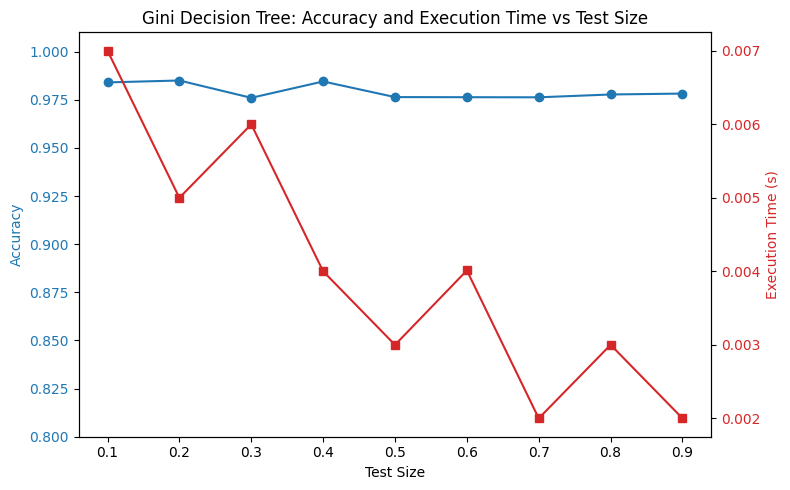

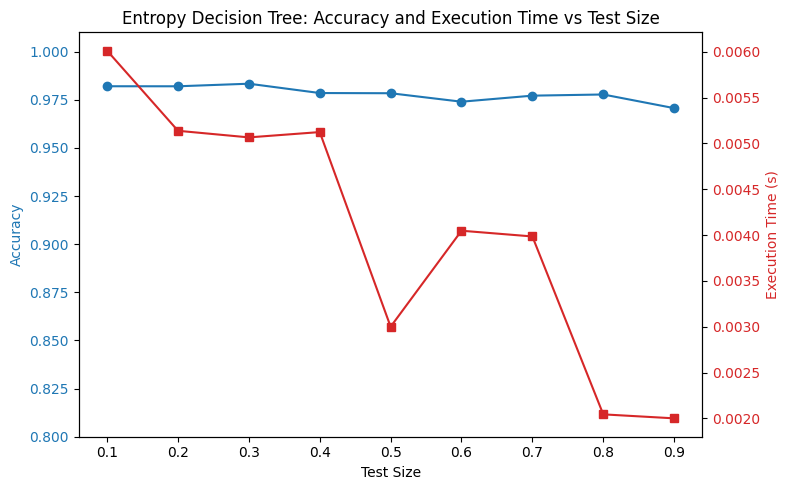

In [9]:
# Plot the accuracy and execution time of the gini decision tree for different test sizes
gini_times = [result[0] for result in gini_tests.results]
gini_scores = [result[1] for result in gini_tests.results]

fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('Test Size')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(test_sizes, gini_scores, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.8, 1.01)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Execution Time (s)', color=color)
ax2.plot(test_sizes, gini_times, marker='s', color=color, label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Gini Decision Tree: Accuracy and Execution Time vs Test Size')
fig.tight_layout()
plt.show()

# Plot the accuracy and execution time of the entropy decision tree for different test sizes
entropy_times = [result[0] for result in entropy_tests.results]
entropy_scores = [result[1] for result in entropy_tests.results]

fig, ax1 = plt.subplots(figsize=(8, 5))

color = 'tab:blue'
ax1.set_xlabel('Test Size')
ax1.set_ylabel('Accuracy', color=color)
ax1.plot(test_sizes, entropy_scores, marker='o', color=color, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0.8, 1.01)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Execution Time (s)', color=color)
ax2.plot(test_sizes, entropy_times, marker='s', color=color, label='Execution Time')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Entropy Decision Tree: Accuracy and Execution Time vs Test Size')
fig.tight_layout()
plt.show()

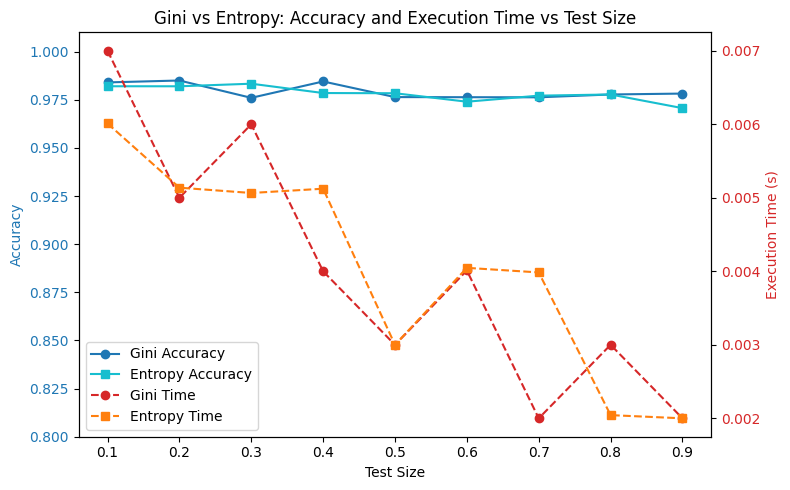

In [10]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Accuracy plot
ax1.set_xlabel('Test Size')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(test_sizes, gini_scores, marker='o', color='tab:blue', label='Gini Accuracy')
ax1.plot(test_sizes, entropy_scores, marker='s', color='tab:cyan', label='Entropy Accuracy')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0.8, 1.01)

# Execution time plot
ax2 = ax1.twinx()
ax2.set_ylabel('Execution Time (s)', color='tab:red')
ax2.plot(test_sizes, gini_times, marker='o', linestyle='--', color='tab:red', label='Gini Time')
ax2.plot(test_sizes, entropy_times, marker='s', linestyle='--', color='tab:orange', label='Entropy Time')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower left')

plt.title('Gini vs Entropy: Accuracy and Execution Time vs Test Size')
fig.tight_layout()
plt.show()

##### Analyze, explain, and comment on the evaluation results

##### How does the Number of training sample affect performance (accuracy, time, etc.)? Explain and draw graphs to support your claims.

Changing the percentage of the test-train split has an interesting performance effect. While I would have expected Gini to be a more faster, it took longer to train and predict than entropy in almost all cases.

The difference in accuracy between the two models seems non-significent. Looking at the confusion matrices, it shows that both models were accurate with little difference between them. Additionally, there was little difference in the number of false negatives to false positives, and each model leaned in opposite directions for their incorrect classifications.

### Tree Pruning (Grace Biggs)

Below, we take our Gini and Entropy trees and post-prune them with a few different techniques - limiting the maximum depth, setting the minimum number of samples needed to split on a node, and cost complexity pruning to remove nodes with low alpha values. To find the best depth limit, the minimum number of samples, and the ideal alpha value we should use, we take advantage of 5-fold cross validation - more specifically, scikit-learn's GridSearchCV function, which performs cross validation on models based on parameters you give it to iterate through and find the best value for.

In [16]:
# Model training
from sklearn.tree import DecisionTreeClassifier # https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
from sklearn.model_selection import GridSearchCV, cross_val_score # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# GridSearchCV is a function that performs Cross Validation on models based on some parameters you
#  give it to iterate through and find the best value for (e.g., max depth, min samples).
# https://stackoverflow.com/questions/35097003/cross-validation-decision-trees-in-sklearn
# gini_tree and entropy_tree
# data_train/data_test/label_train/label_test

# Max Depth 5-fold Cross Validation
params = {'max_depth': range(1, 21)}
grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train) # Best to do CV on training set.
depth_gini = grid_search.best_estimator_
print(depth_gini)

grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='entropy', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train) # Best to do CV on training set.
depth_entropy = grid_search.best_estimator_
print(depth_entropy)

# Minimum-Sample 5-fold Cross Validation
params = {'min_samples_leaf': range(1, 101, 5)}
grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train)
minsamp_gini = grid_search.best_estimator_
print(minsamp_gini)

grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='entropy', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train)
minsamp_entropy = grid_search.best_estimator_
print(minsamp_entropy)

# Cost Complexity Pruning
# https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py
ccp_base_gini = DecisionTreeClassifier(criterion='gini', random_state=state_value)
path = ccp_base_gini.cost_complexity_pruning_path(data_train, label_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1] # Remove the max-effective alpha value since it's only one node
params = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='gini', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train) 
ccp_gini = grid_search.best_estimator_
print(ccp_gini)

ccp_base_entropy = DecisionTreeClassifier(criterion='entropy', random_state=state_value)
path = ccp_base_entropy.cost_complexity_pruning_path(data_train, label_train)
ccp_alphas, impurities = path.ccp_alphas[:-1], path.impurities[:-1] # Remove the max-effective alpha value since it's only one node
params = {'ccp_alpha': ccp_alphas}
grid_search = GridSearchCV(
    DecisionTreeClassifier(criterion='entropy', random_state=state_value),
    params,
    cv=5,
    scoring='accuracy'
)
grid_search.fit(data_train, label_train) 
ccp_entropy = grid_search.best_estimator_
print(ccp_entropy)

DecisionTreeClassifier(max_depth=5, random_state=42)
DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)
DecisionTreeClassifier(random_state=42)
DecisionTreeClassifier(criterion='entropy', min_samples_leaf=21,
                       random_state=42)
DecisionTreeClassifier(ccp_alpha=0.0003960995200044014, random_state=42)
DecisionTreeClassifier(ccp_alpha=0.00237996980608475, criterion='entropy',
                       random_state=42)


#### Model Accuracy (Grace Biggs)

After building our pruned trees, we compare their accuracy and training and evaluation times against the fully-grown trees'. There are only negligible differences between each tree's accuracy - each at 97% - and all prediction times were so fast they've seemingly been confused for floating point errors and rounded down to 0. This leaves the training time as the only real metric that lets us glean information about the models' performance with the new pruning. Indeed, there's a major difference with the full entropy tree taking 0.006s to train, compared to the pruned entropy trees which average 0.0046s - nearly 25% faster. Of these, the minimum-sample entropy tree had the best performance of .004s, followed closely by the depth entropy tree. Looking at Gini, it seems the original tree was faster than any others, though the pruned trees aren't quite out of the running by virtue of being just *slightly* more accurate by fractions of a percent. 

In [20]:
models = {'depth_gini': depth_gini, 
          'depth_entropy': depth_entropy, 
          'minsamp_gini': minsamp_gini, 
          'minsamp_entropy': minsamp_entropy, 
          'ccp_gini': ccp_gini, 
          'ccp_entropy': ccp_entropy,
          'gini_tree': gini_tree,
          'entropy_tree': entropy_tree
         }
metrics = {}

for label, model in models.items():
    start = time.time()
    model.fit(data_train, label_train)
    train_time = time.time() - start

    start = time.time()
    label_pred = model.predict(data_test)
    pred_time = time.time() - start

    accuracy = sklearn.metrics.accuracy_score(label_test, label_pred)

    metrics[label] = {'train_time': train_time,
                      'pred_time': pred_time,
                      'accuracy': accuracy
                     }

print(metrics)

{'depth_gini': {'train_time': 0.004802703857421875, 'pred_time': 0.0, 'accuracy': 0.978978978978979}, 'depth_entropy': {'train_time': 0.004169940948486328, 'pred_time': 0.0, 'accuracy': 0.9769769769769769}, 'minsamp_gini': {'train_time': 0.004183769226074219, 'pred_time': 0.0, 'accuracy': 0.974974974974975}, 'minsamp_entropy': {'train_time': 0.004001617431640625, 'pred_time': 0.0, 'accuracy': 0.975975975975976}, 'ccp_gini': {'train_time': 0.004670619964599609, 'pred_time': 0.0, 'accuracy': 0.978978978978979}, 'ccp_entropy': {'train_time': 0.005681276321411133, 'pred_time': 0.0, 'accuracy': 0.978978978978979}, 'gini_tree': {'train_time': 0.0039997100830078125, 'pred_time': 0.0, 'accuracy': 0.974974974974975}, 'entropy_tree': {'train_time': 0.00605320930480957, 'pred_time': 0.0, 'accuracy': 0.972972972972973}}


Plot and comment on all pruned trees

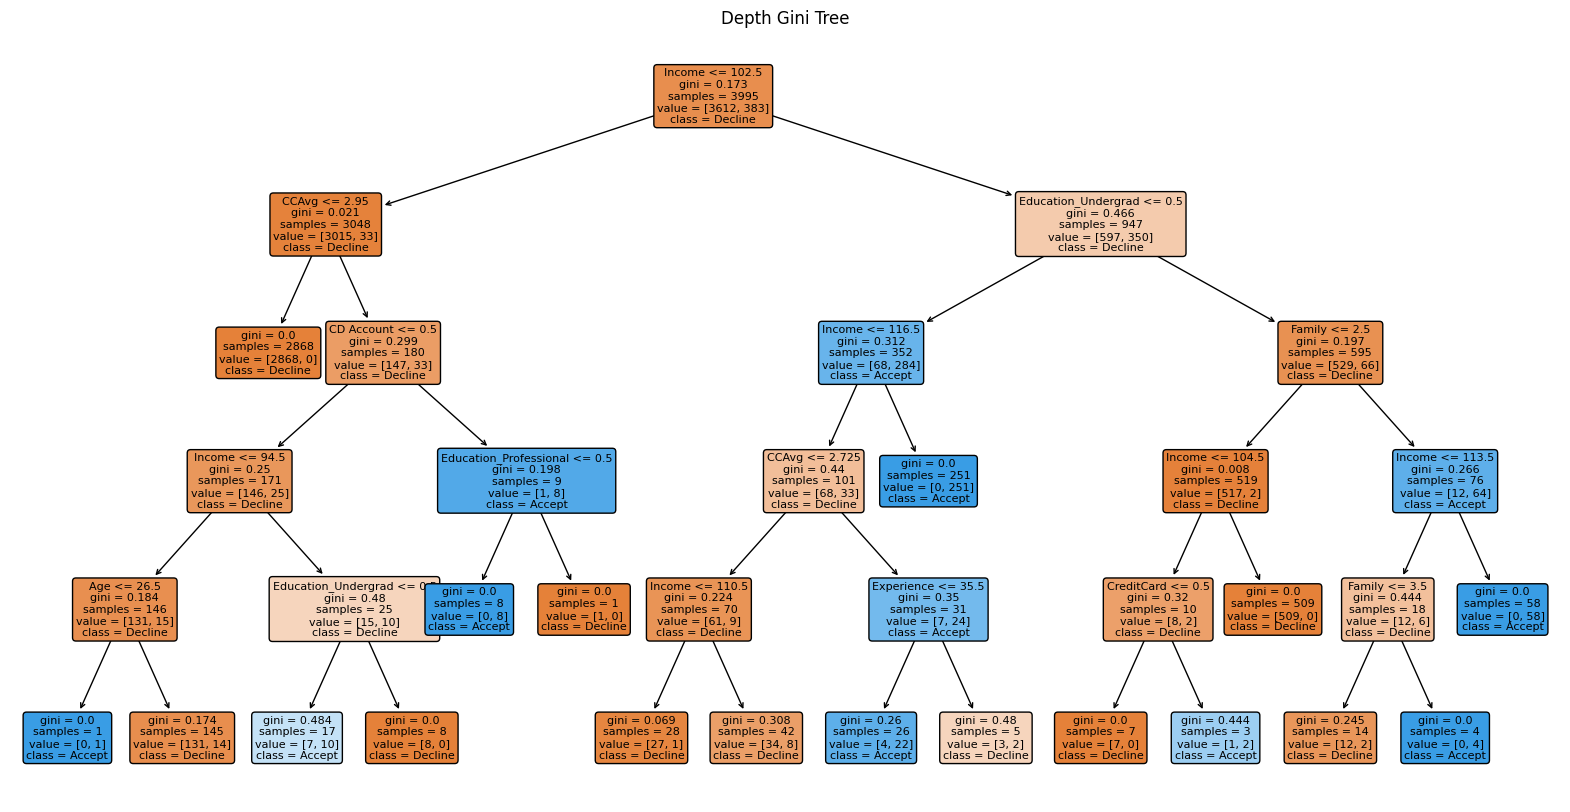

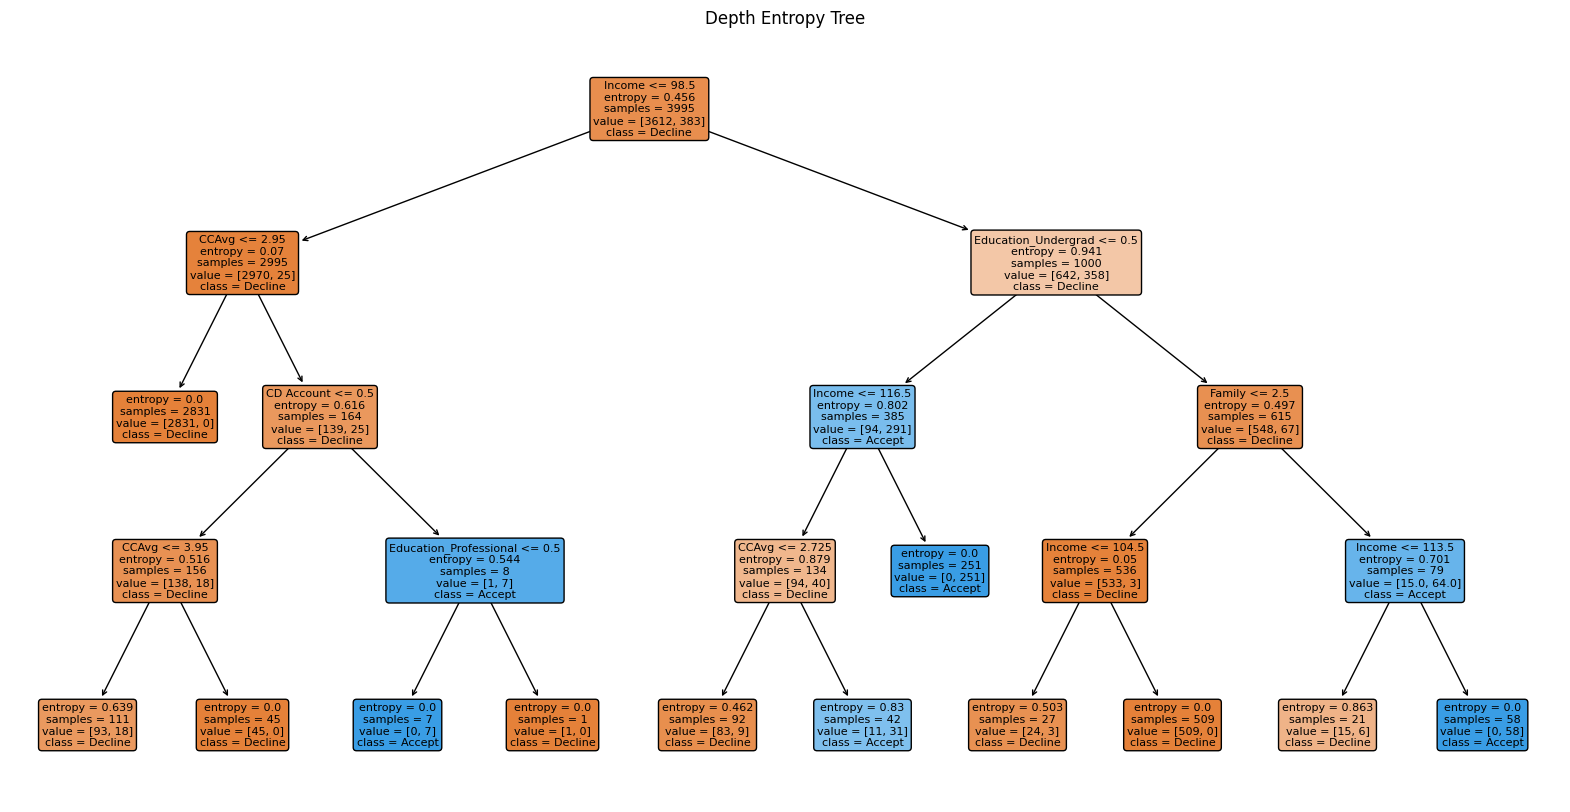

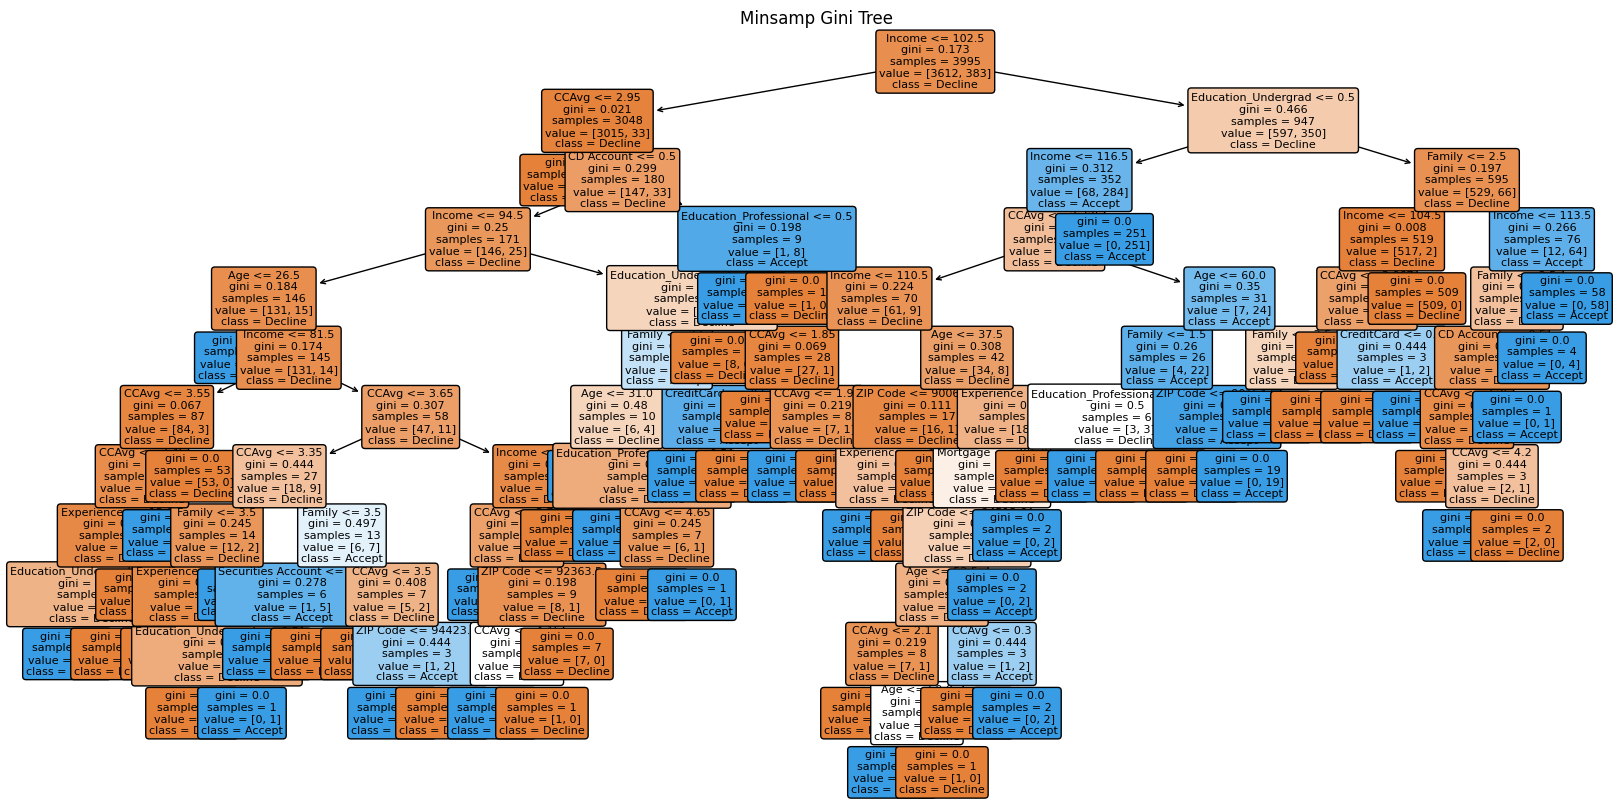

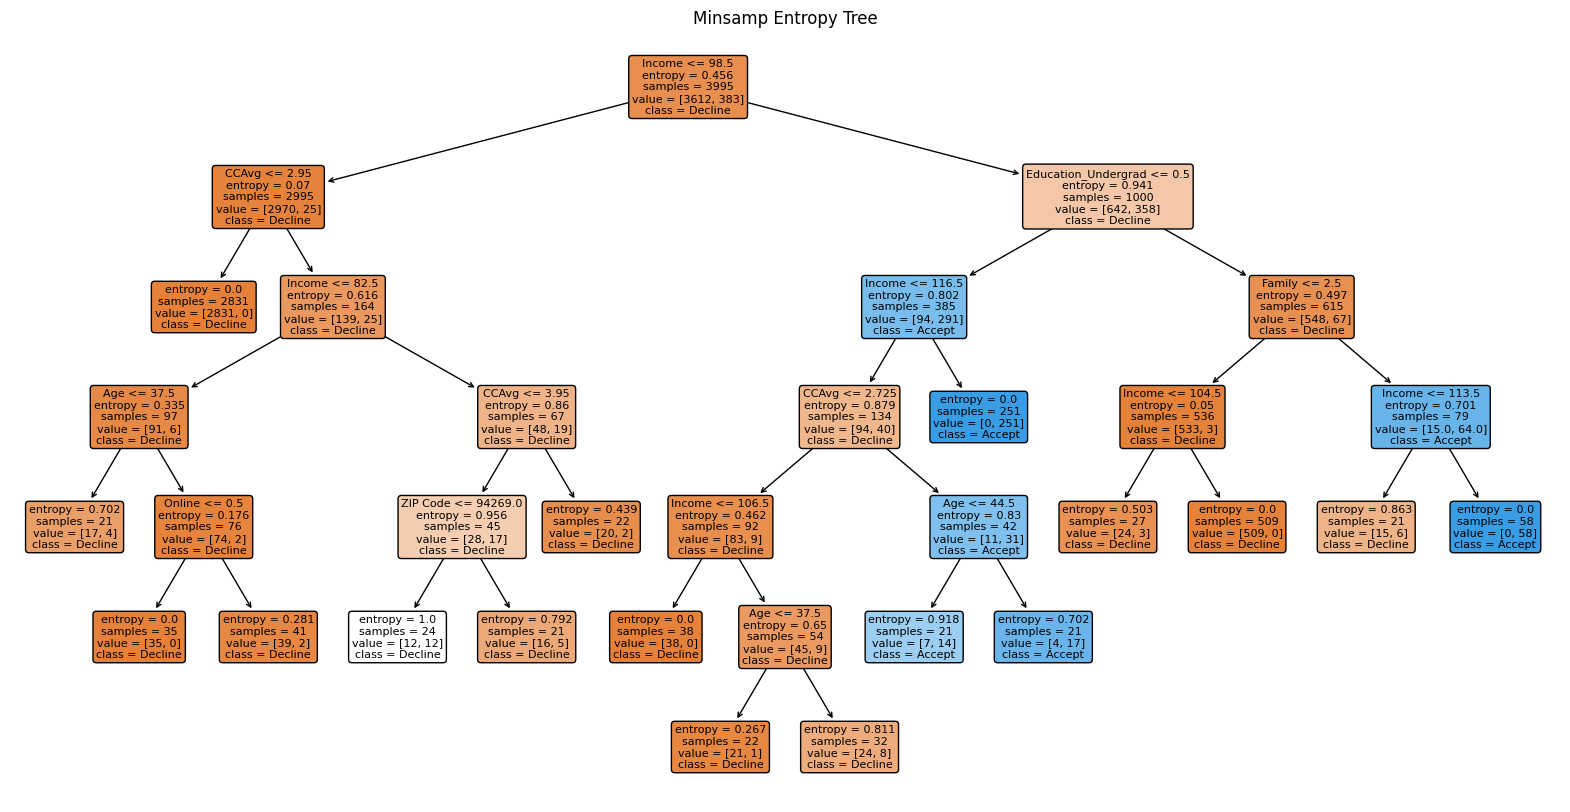

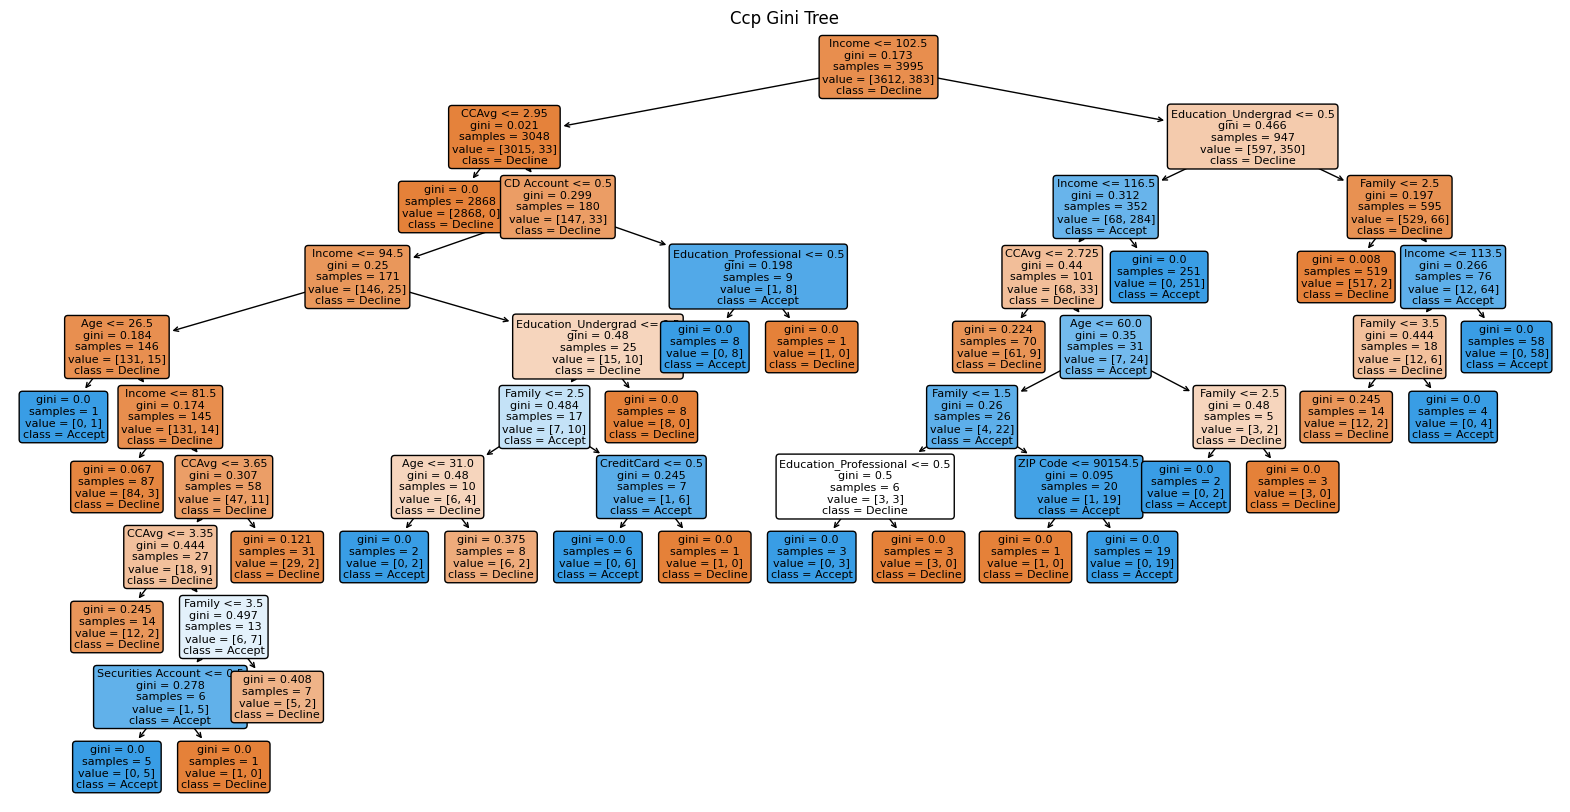

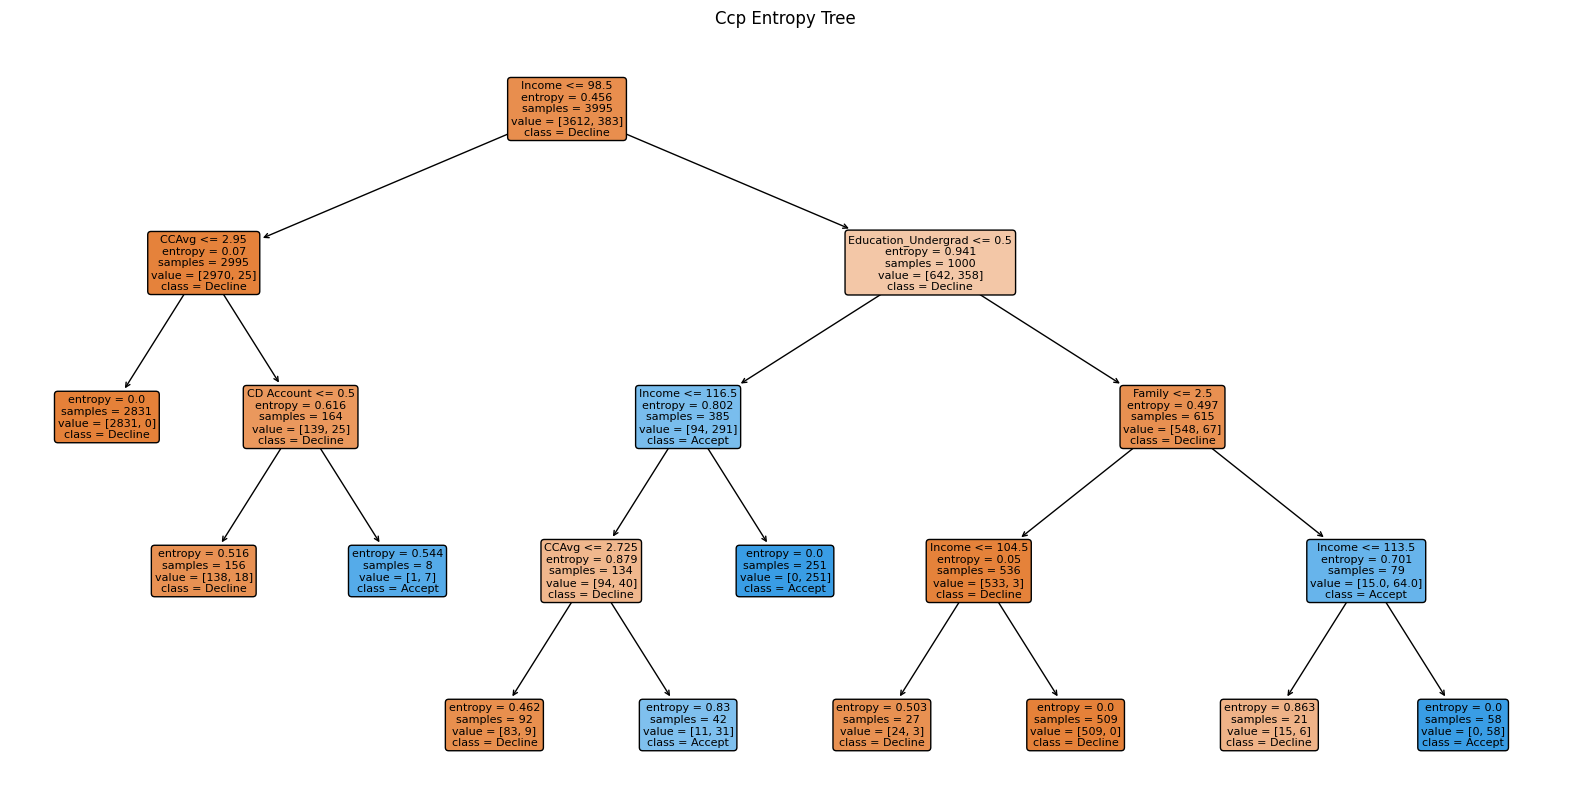

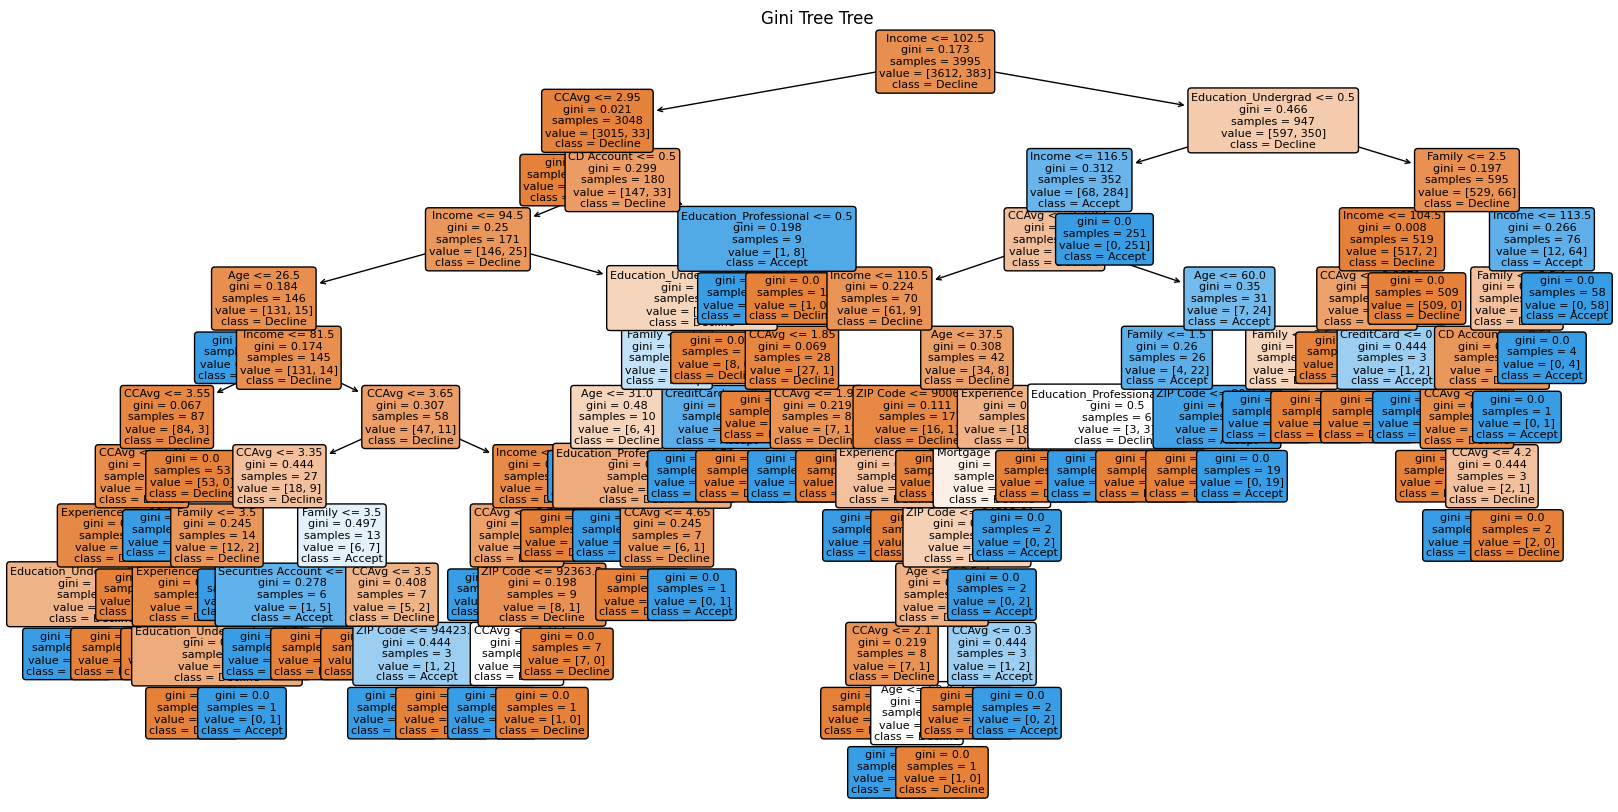

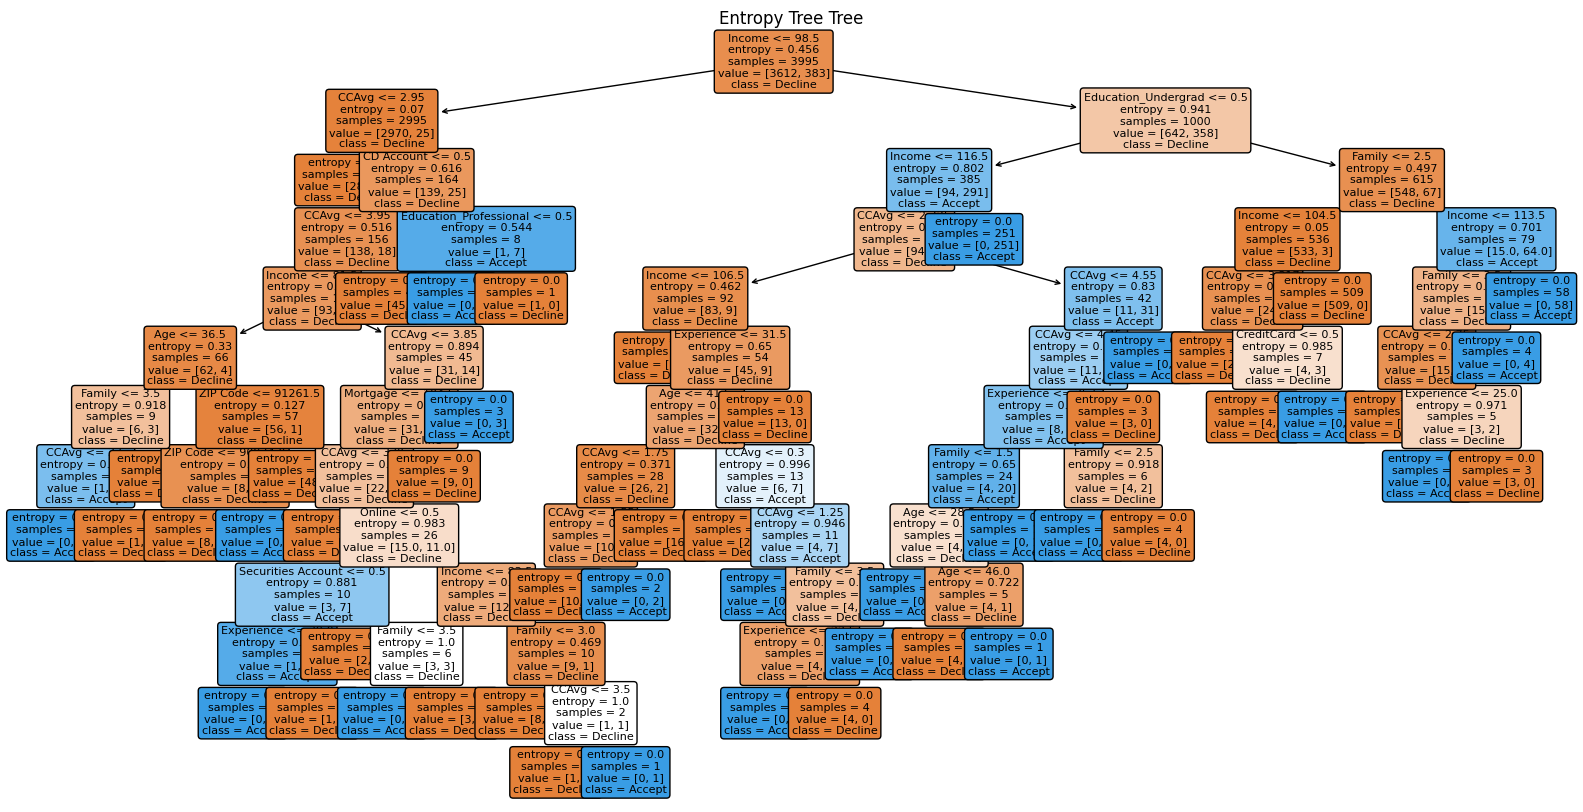

In [22]:
feature_names = list(ct.named_transformers_['cat'].get_feature_names_out(['Education']))
feature_names += [col for col in X.columns if col != 'Education']

for label, model in models.items():
    plt.figure(figsize=(20,10))
    sklearn.tree.plot_tree(model, filled=True, feature_names=feature_names, 
                           class_names=["Decline", "Accept"], fontsize=8, rounded=True)
    plt.title(f"{label.capitalize().replace('_', ' ').title()} Tree")
    plt.show()

Conclusion/Summary

